In [1]:
# Install the required packages
# !pip install -q yfinance==0.2.44 # Version 0.2.45 (lastest as of 2024-10-21) has an import error.
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q scipy
# !pip install -q matplotlib
# !pip install -q holoviews

In [2]:
# Import standard library modules
import sys

# Set the relative path to the project root directory
relative_path_to_root = "../../"

# Add the project root to the system path for importing in-house modules
sys.path.append(relative_path_to_root)

# Import in-house modules from the 'utilities' package
from utilities import calculate_bollinger_bands, calculate_rsi, calculate_daily_volatility
from utilities import print_title, print_label, print_footer
from utilities import generate_trading_signals
from utilities import fetch_and_download_sp500_data, sp500_data_for_today
from utilities import print_dataframe_report, save_data
from utilities import temporal_train_test_split

In [3]:
# Import libraries for data analysis and visualization
import pandas as pd

# Import libraries for signal processing and peak detection
from scipy.signal import find_peaks
import numpy as np

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

# Import libraries for data storage and retrieval
from pathlib import Path

In [4]:
# Set display options for Pandas (optional, but often helpful)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Suppress scientific notation

### Data Collection
___

In [5]:
# Syntax: fetch_and_download_sp500_data(start_date="YYYY-MM-DD", end_date="YYYY-MM-DD")
# To add an end date, put end_date="YYYY-MM-DD"

historical_data = fetch_and_download_sp500_data(start_date="2007-01-01")

display(historical_data.head(2))
display(historical_data.tail(2))

[*********************100%***********************]  501 of 501 completed


╔═══════════════════════════════════════════════════════════════╗
║            Download Report for S&P 500 `adj close`            ║
╠═══════════════════════════════════════════════════════════════╣
║ Total Requested Tickers:       |             501              ║
║ Total Downloaded Tickers:      |             501              ║
║ Requested Date Range:          |   2007-01-01 to 2024-10-28   ║
║ Downloaded Date Range:         |   2007-01-03 to 2024-10-25   ║
║                       S&P 500 Data Downloaded Successfully... ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03 00:00:00+00:00,21.975,2.527,0.000,0.000,15.535,7.496,26.394,39.920,21.268,20.791,...,71.602,14.521,55.839,12.268,40.008,0.000,14.979,67.253,34.880,0.000
2007-01-04 00:00:00+00:00,22.046,2.583,0.000,0.000,15.830,7.492,26.988,40.820,21.637,20.674,...,71.779,14.375,55.862,12.278,39.258,0.000,14.938,68.753,34.680,0.000


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-24 00:00:00+00:00,130.690,230.570,189.650,132.750,116.540,107.040,364.230,482.870,229.680,56.500,...,290.530,32.130,97.900,65.110,119.590,130.650,133.160,104.000,362.050,181.500
2024-10-25 00:00:00+00:00,130.190,231.410,187.850,134.580,114.220,105.300,360.800,483.720,230.170,56.560,...,290.450,31.800,97.990,64.460,119.490,130.420,133.040,102.350,360.090,180.010


In [6]:
# Syntax: sp500_data_for_today(time="15:59:00"):
# The default time is 15:59:00, which is the last minute of the trading day (3:59 PM)
# The time must be in the format "HH:MM:SS"

todays_data = sp500_data_for_today(time="15:59:00")

╔═══════════════════════════════════════════════════════════════╗
║      Download Report for S&P 500  `close` for 2024-10-28      ║
╠═══════════════════════════════════════════════════════════════╣
║ Total Requested Tickers:       |             501              ║
║ Requested Time:                |           15:59:00           ║
║ Downloaded Date:               |          2024-10-28          ║
║                       S&P 500 Data Downloaded Successfully... ║
╚═══════════════════════════════════════════════════════════════╝


In [7]:
data = pd.concat([historical_data, todays_data], axis=0)

print("Shape:", data.shape)
display(data.head(10))
display(data.tail(10))

Shape: (4486, 501)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2007-01-03 00:00:00+00:00,21.975,2.527,0.000,0.000,15.535,7.496,26.394,39.920,21.268,20.791,...,71.602,14.521,55.839,12.268,40.008,0.000,14.979,67.253,34.880,0.000
2007-01-04 00:00:00+00:00,22.046,2.583,0.000,0.000,15.830,7.492,26.988,40.820,21.637,20.674,...,71.779,14.375,55.862,12.278,39.258,0.000,14.938,68.753,34.680,0.000
2007-01-05 00:00:00+00:00,21.841,2.565,0.000,0.000,15.830,7.419,26.611,40.620,21.391,20.642,...,71.033,14.329,56.193,12.032,39.538,0.000,14.808,68.709,34.330,0.000
2007-01-08 00:00:00+00:00,21.764,2.578,0.000,0.000,15.887,7.462,26.996,40.450,21.559,20.745,...,70.553,14.455,57.254,12.032,39.220,0.000,14.773,68.264,34.400,0.000
2007-01-09 00:00:00+00:00,21.789,2.792,0.000,0.000,16.027,7.392,26.930,39.630,21.527,20.240,...,69.825,14.381,57.480,12.027,38.918,0.000,14.829,68.308,34.340,0.000
2007-01-10 00:00:00+00:00,21.591,2.926,0.000,0.000,16.079,7.423,27.090,39.220,21.902,20.064,...,69.025,14.295,59.423,12.090,38.324,0.000,15.007,68.081,34.370,0.000
2007-01-11 00:00:00+00:00,21.591,2.889,0.000,0.000,16.067,7.392,26.981,39.880,21.948,20.544,...,69.345,14.511,60.276,12.074,38.318,0.000,15.308,68.474,34.440,0.000
2007-01-12 00:00:00+00:00,21.527,2.854,0.000,0.000,16.099,7.382,27.554,39.960,21.980,20.077,...,71.086,14.621,60.606,11.975,39.225,0.000,15.275,68.631,35.500,0.000
2007-01-16 00:00:00+00:00,21.488,2.929,0.000,0.000,16.150,7.402,26.916,40.050,21.870,20.116,...,71.691,14.601,62.497,12.048,38.669,0.000,15.362,68.648,35.550,0.000
2007-01-17 00:00:00+00:00,21.059,2.864,0.000,0.000,16.450,7.346,27.221,40.200,21.520,20.220,...,71.673,14.447,61.343,12.064,39.117,0.000,15.270,69.180,35.520,0.000


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-10-15 00:00:00+00:00,144.580,233.850,191.860,133.270,116.050,108.060,368.660,508.030,225.870,57.670,...,291.140,33.050,99.220,63.430,120.350,136.680,133.220,104.600,375.300,192.390
2024-10-16 00:00:00+00:00,139.110,231.780,190.460,135.150,117.820,107.470,372.260,502.540,227.490,58.290,...,291.300,33.450,100.240,64.010,120.660,137.460,133.350,105.460,375.500,194.440
2024-10-17 00:00:00+00:00,137.420,232.150,188.570,136.020,117.890,108.250,375.150,496.830,227.340,58.630,...,291.140,32.800,97.990,63.250,120.350,135.160,133.730,104.950,373.840,191.000
2024-10-18 00:00:00+00:00,138.830,235.000,188.860,136.450,119.390,108.530,376.860,494.900,228.330,56.400,...,290.030,33.060,99.440,64.070,120.010,134.320,134.270,106.310,375.450,193.280
2024-10-21 00:00:00+00:00,136.760,236.480,186.540,137.190,116.990,108.500,376.030,497.710,225.670,56.130,...,290.500,32.290,98.370,63.430,120.080,132.520,134.000,105.200,372.590,189.450
2024-10-22 00:00:00+00:00,133.460,235.860,188.760,135.590,116.120,107.790,371.790,493.110,224.620,55.690,...,291.740,31.650,99.400,63.680,120.700,131.370,133.360,104.260,372.000,189.510
2024-10-23 00:00:00+00:00,133.030,230.760,187.880,131.920,117.010,107.000,370.630,485.030,226.850,56.080,...,291.920,31.850,97.680,64.320,120.270,131.720,134.020,104.700,368.090,188.990
2024-10-24 00:00:00+00:00,130.690,230.570,189.650,132.750,116.540,107.040,364.230,482.870,229.680,56.500,...,290.530,32.130,97.900,65.110,119.590,130.650,133.160,104.000,362.050,181.500
2024-10-25 00:00:00+00:00,130.190,231.410,187.850,134.580,114.220,105.300,360.800,483.720,230.170,56.560,...,290.450,31.800,97.990,64.460,119.490,130.420,133.040,102.350,360.090,180.010
2024-10-28 15:59:00-04:00,131.620,233.490,189.740,135.820,114.130,105.650,361.450,481.170,230.140,57.240,...,292.120,31.970,98.610,64.510,118.960,130.835,134.870,103.550,363.530,182.850


In [8]:
# Inspect for missing values
print("Missing Values:", data.isnull().sum().sum())

Missing Values: 0


### Feature Engineering
___

In [9]:
def generate_directions(data):
    next_day = data.shift(-1)  # Next day's price data
    prev_day = data.shift(1)   # Previous day's price data

    today_to_tomorrow = np.sign(next_day - data)
    yesterday_to_today = np.sign(data - prev_day)

    return today_to_tomorrow, yesterday_to_today

In [10]:
upper_band, lower_band = calculate_bollinger_bands(data)

today_to_tomorrow, yesterday_to_today = generate_directions(data)

# Create a dictionary of feature dataframes
feature_dataframes = {
    # Shifted Adjusted Close Prices
    "next_day_adj_close": data.shift(-1).copy(),
    "prev_day_adj_close": data.shift(1).copy(),

    # Directional Indicators
    "today_to_tomorrow": today_to_tomorrow.copy(),
    "yesterday_to_today": yesterday_to_today.copy(),

    # Returns and Volatility Calculations
    "returns": data.pct_change().copy(),
    "daily_volatility": data.apply(calculate_daily_volatility).copy(),

    # Technical Indicators
    "rsi": data.apply(calculate_rsi).copy(),
    "sma_50": data.rolling(window=50).mean().copy(),
    "sma_100": data.rolling(window=100).mean().copy(),
    "sma_200": data.rolling(window=200).mean().copy(),
    "upper_band": upper_band.copy(),
    "lower_band": lower_band.copy(),

    # Support and Resistance Levels
    "support": data.rolling(window=50).min().copy(),
    "resistance": data.rolling(window=50).max().copy(),

    # Trading Signals
    "actions": data.apply(generate_trading_signals).copy()
}

In [11]:
# Inspect DataFrames
select_df = "today_to_tomorrow"

inspect_df = feature_dataframes[select_df].copy()

print_dataframe_report(inspect_df, select_df)
display(inspect_df.head(5))
display(inspect_df.tail(5))

╔═══════════════════════════════════════════════════════════════╗
║             `Today_to_tomorrow` DataFrame Report              ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   | 2007-01-03 00:00:00+00:00 to 2024-10-28 15:59:00-04:00 ║
║ `Today_to_tomorrow` Data Ty... |      [dtype('float64')]      ║
║ `Today_to_tomorrow` DF Shape:  |         (4486, 501)          ║
║ Columns with null values:      |             501              ║
║ Rows with null values:         |              1               ║
║ Total Unique Values:           |             1503             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2007-01-03 00:00:00+00:00,1.000,1.000,0.000,0.000,1.000,-1.000,1.000,1.000,1.000,-1.000,...,1.000,-1.000,1.000,1.000,-1.000,0.000,-1.000,1.000,-1.000,0.000
2007-01-04 00:00:00+00:00,-1.000,-1.000,0.000,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,1.000,-1.000,1.000,0.000,-1.000,-1.000,-1.000,0.000
2007-01-05 00:00:00+00:00,-1.000,1.000,0.000,0.000,1.000,1.000,1.000,-1.000,1.000,1.000,...,-1.000,1.000,1.000,0.000,-1.000,0.000,-1.000,-1.000,1.000,0.000
2007-01-08 00:00:00+00:00,1.000,1.000,0.000,0.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,1.000,-1.000,-1.000,0.000,1.000,1.000,-1.000,0.000
2007-01-09 00:00:00+00:00,-1.000,1.000,0.000,0.000,1.000,1.000,1.000,-1.000,1.000,-1.000,...,-1.000,-1.000,1.000,1.000,-1.000,0.000,1.000,-1.000,1.000,0.000


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-10-22 00:00:00+00:00,-1.000,-1.000,-1.000,-1.000,1.000,-1.000,-1.000,-1.000,1.000,1.000,...,1.000,1.000,-1.000,1.000,-1.000,1.000,1.000,1.000,-1.000,-1.000
2024-10-23 00:00:00+00:00,-1.000,-1.000,1.000,1.000,-1.000,1.000,-1.000,-1.000,1.000,1.000,...,-1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
2024-10-24 00:00:00+00:00,-1.000,1.000,-1.000,1.000,-1.000,-1.000,-1.000,1.000,1.000,1.000,...,-1.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
2024-10-25 00:00:00+00:00,1.000,1.000,1.000,1.000,-1.000,1.000,1.000,-1.000,-1.000,1.000,...,1.000,1.000,1.000,1.000,-1.000,1.000,1.000,1.000,1.000,1.000
2024-10-28 15:59:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing
___

In [12]:
# Initialize an empty dictionary for clean dataframes
clean_feature_dataframes = {}

for key, df in feature_dataframes.items():
    
    # Perform forward and backward filling, and then fill remaining NaNs with 0 or mean
    filled_df = df.copy()
    # filled_df.ffill(inplace=True)
    # filled_df.bfill(inplace=True)
    
    # Store the cleaned dataframe in the new dictionary
    clean_feature_dataframes[key] = filled_df

In [13]:
# Inspect DataFrames
select_df = "prev_day_adj_close"

inspect_df = clean_feature_dataframes[select_df]

print_dataframe_report(inspect_df, select_df)
display(inspect_df.head(5))
display(inspect_df.tail(5))

╔═══════════════════════════════════════════════════════════════╗
║             `Prev_day_adj_close` DataFrame Report             ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   | 2007-01-03 00:00:00+00:00 to 2024-10-28 15:59:00-04:00 ║
║ `Prev_day_adj_close` Data T... |      [dtype('float64')]      ║
║ `Prev_day_adj_close` DF Shape: |         (4486, 501)          ║
║ Columns with null values:      |             501              ║
║ Rows with null values:         |              1               ║
║ Total Unique Values:           |           1914048            ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2007-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04 00:00:00+00:00,21.975,2.527,0.000,0.000,15.535,7.496,26.394,39.920,21.268,20.791,...,71.602,14.521,55.839,12.268,40.008,0.000,14.979,67.253,34.880,0.000
2007-01-05 00:00:00+00:00,22.046,2.583,0.000,0.000,15.830,7.492,26.988,40.820,21.637,20.674,...,71.779,14.375,55.862,12.278,39.258,0.000,14.938,68.753,34.680,0.000
2007-01-08 00:00:00+00:00,21.841,2.565,0.000,0.000,15.830,7.419,26.611,40.620,21.391,20.642,...,71.033,14.329,56.193,12.032,39.538,0.000,14.808,68.709,34.330,0.000
2007-01-09 00:00:00+00:00,21.764,2.578,0.000,0.000,15.887,7.462,26.996,40.450,21.559,20.745,...,70.553,14.455,57.254,12.032,39.220,0.000,14.773,68.264,34.400,0.000


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2024-10-22 00:00:00+00:00,136.760,236.480,186.540,137.190,116.990,108.500,376.030,497.710,225.670,56.130,...,290.500,32.290,98.370,63.430,120.080,132.520,134.000,105.200,372.590,189.450
2024-10-23 00:00:00+00:00,133.460,235.860,188.760,135.590,116.120,107.790,371.790,493.110,224.620,55.690,...,291.740,31.650,99.400,63.680,120.700,131.370,133.360,104.260,372.000,189.510
2024-10-24 00:00:00+00:00,133.030,230.760,187.880,131.920,117.010,107.000,370.630,485.030,226.850,56.080,...,291.920,31.850,97.680,64.320,120.270,131.720,134.020,104.700,368.090,188.990
2024-10-25 00:00:00+00:00,130.690,230.570,189.650,132.750,116.540,107.040,364.230,482.870,229.680,56.500,...,290.530,32.130,97.900,65.110,119.590,130.650,133.160,104.000,362.050,181.500
2024-10-28 15:59:00-04:00,130.190,231.410,187.850,134.580,114.220,105.300,360.800,483.720,230.170,56.560,...,290.450,31.800,97.990,64.460,119.490,130.420,133.040,102.350,360.090,180.010


### Exploratory Data Analysis (EDA):
___

In [14]:
# Check for missing values in the cleaned dataframes
for name, df in clean_feature_dataframes.items():
    print(f"`{name}` DataFrame Missing Values:", df.isnull().sum().sum())

`next_day_adj_close` DataFrame Missing Values: 501
`prev_day_adj_close` DataFrame Missing Values: 501
`today_to_tomorrow` DataFrame Missing Values: 501
`yesterday_to_today` DataFrame Missing Values: 501
`returns` DataFrame Missing Values: 162562
`daily_volatility` DataFrame Missing Values: 172674
`rsi` DataFrame Missing Values: 162925
`sma_50` DataFrame Missing Values: 24549
`sma_100` DataFrame Missing Values: 49599
`sma_200` DataFrame Missing Values: 99699
`upper_band` DataFrame Missing Values: 9519
`lower_band` DataFrame Missing Values: 9519
`support` DataFrame Missing Values: 24549
`resistance` DataFrame Missing Values: 24549
`actions` DataFrame Missing Values: 164040


In [15]:
# for name, df in clean_feature_dataframes.items():
#     print_title(f"`{name}` DataFrame", closed_corners=False)
#     print_label("Shape:", f"{df.shape}")
#     print_label("Length:", f"{len(df)}", closed_corners=True)

#     display(df.head())

### Merging S&P Data
___

In [16]:
# Assign clean dataframes to individual variables for easier access

# Shifted Adjusted Close Prices
next_day_adj_close = clean_feature_dataframes["next_day_adj_close"]
prev_day_adj_close = clean_feature_dataframes["prev_day_adj_close"]

# Directional Indicators
today_to_tomorrow = clean_feature_dataframes["today_to_tomorrow"]
yesterday_to_today = clean_feature_dataframes["yesterday_to_today"]

# Returns and Volatility Calculations
returns = clean_feature_dataframes["returns"]
daily_volatility = clean_feature_dataframes["daily_volatility"]

# Technical Indicators
rsi = clean_feature_dataframes["rsi"]
sma_50 = clean_feature_dataframes["sma_50"]
sma_100 = clean_feature_dataframes["sma_100"]
sma_200 = clean_feature_dataframes["sma_200"]
upper_band = clean_feature_dataframes["upper_band"]
lower_band = clean_feature_dataframes["lower_band"]

# Support and Resistance Levels
support = clean_feature_dataframes["support"]
resistance = clean_feature_dataframes["resistance"]

# Trading Signals
actions = clean_feature_dataframes["actions"]

In [17]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)

indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Today to Tomorrow': today_to_tomorrow.values.flatten(),
    'Yesterday to Today': yesterday_to_today.values.flatten(),
    'Next Day Close': next_day_adj_close.values.flatten(),
    'Previous Day Close': prev_day_adj_close.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
},
)

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
# indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Convert to datetime (Without timezone)
indicators_df['Date'] = pd.to_datetime(indicators_df['Date'], utc=True).dt.date
indicators_df['Date'] = pd.to_datetime(indicators_df['Date'])

# Optimize the DataFrame by converting data types to more memory-efficient types
indicators_df[['Ticker', 'Action']] = indicators_df[['Ticker', 'Action']].astype('category')
float_cols = indicators_df.select_dtypes(include=['float64']).columns
indicators_df[float_cols] = indicators_df[float_cols].astype('float32')

# Display DataFrame
print_title(f"`indicators_df` Shape: {indicators_df.shape}")
display(indicators_df.head())
display(indicators_df.tail())

╔═══════════════════════════════════════════════════════════════╗
║             `indicators_df` Shape: (2247486, 18)              ║
╚═══════════════════════════════════════════════════════════════╝


,Date,Ticker,Adjusted Close,Today to Tomorrow,Yesterday to Today,Next Day Close,Previous Day Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2007-01-03,A,21.975,1.000,NaN,22.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,AAPL,2.527,1.000,NaN,2.583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-03,ABBV,0.000,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-03,ABNB,0.000,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-03,ABT,15.535,1.000,NaN,15.830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Date,Ticker,Adjusted Close,Today to Tomorrow,Yesterday to Today,Next Day Close,Previous Day Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
2247481,2024-10-28,XYL,130.835,NaN,1.000,NaN,130.420,0.003,0.009,39.970,133.478,134.334,130.950,138.419,129.504,126.710,137.530,NaN
2247482,2024-10-28,YUM,134.870,NaN,1.000,NaN,133.040,0.014,0.007,50.768,134.574,133.395,134.047,138.693,130.995,129.710,139.920,NaN
2247483,2024-10-28,ZBH,103.550,NaN,1.000,NaN,102.350,0.012,0.011,56.672,107.229,107.884,115.284,107.086,101.508,101.770,115.912,NaN
2247484,2024-10-28,ZBRA,363.530,NaN,1.000,NaN,360.090,0.010,0.010,43.505,356.281,337.452,311.584,380.047,359.121,320.770,377.680,NaN
2247485,2024-10-28,ZTS,182.850,NaN,1.000,NaN,180.010,0.016,0.013,42.452,189.079,183.390,179.182,197.458,181.457,180.010,196.480,NaN


### Remove data from 2007 after obtaining values

In [18]:
# Remove dates from `2007-01-01` to `2007-12-31`
remove_date_start = "2007-01-01"
remove_date_end = "2007-12-31"

# Filter out the dates to remove
remove_dates_filter = (indicators_df['Date'] >= remove_date_start) & (indicators_df['Date'] <= remove_date_end)

# Remove the dates from the DataFrame
clean_indicators_df = indicators_df.loc[~remove_dates_filter].copy()

# print first date and last date (first and last row date column)
print("First Date:", clean_indicators_df['Date'].iloc[0])
print("Last Date:", clean_indicators_df['Date'].iloc[-1])

First Date: 2008-01-02 00:00:00
Last Date: 2024-10-28 00:00:00


In [24]:
# Export to a new CSV file
file_name = f"updated_w_nas.csv"
file_path = f"../../data/raw_data/{file_name}"

save_data(clean_indicators_df, file_path)

╔═══════════════════════════════════════════════════════════════╗
║         File saved and zipped as `updated_w_nas.zip`          ║
╚═══════════════════════════════════════════════════════════════╝


### Data Visualization
___

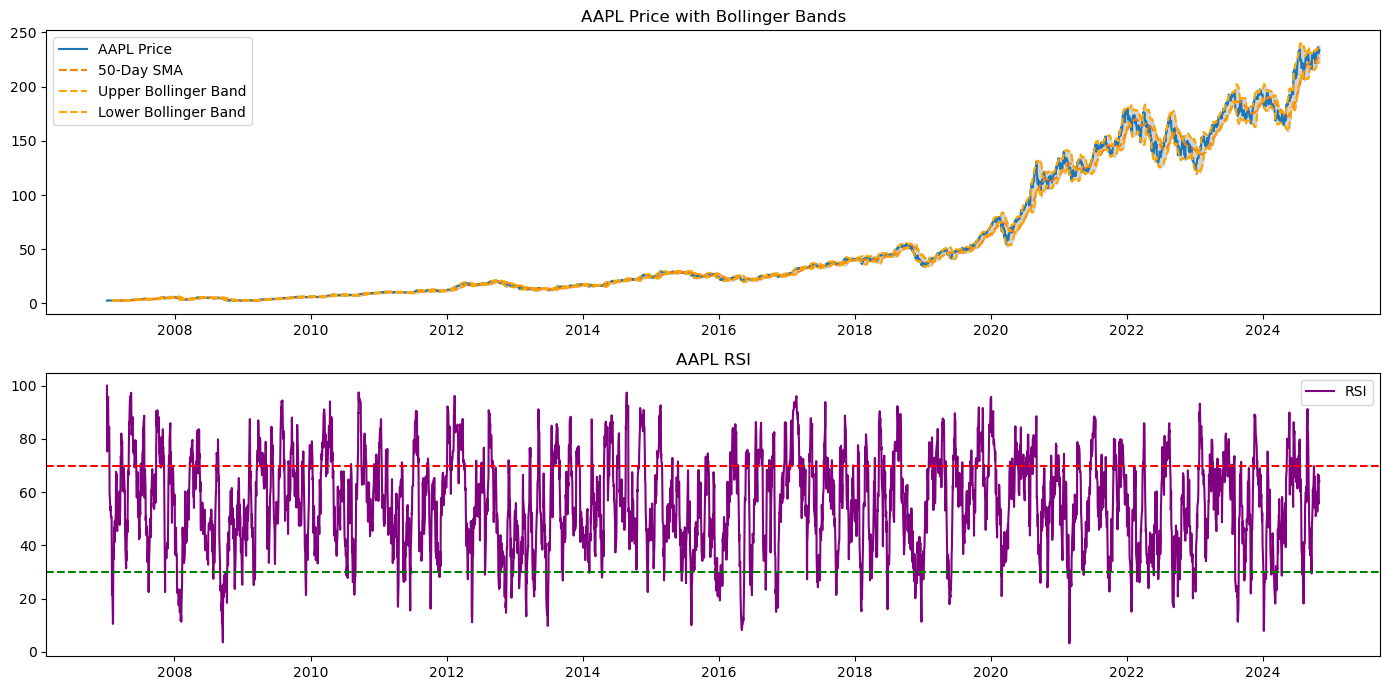

In [20]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [21]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [index]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [index]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [index]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]

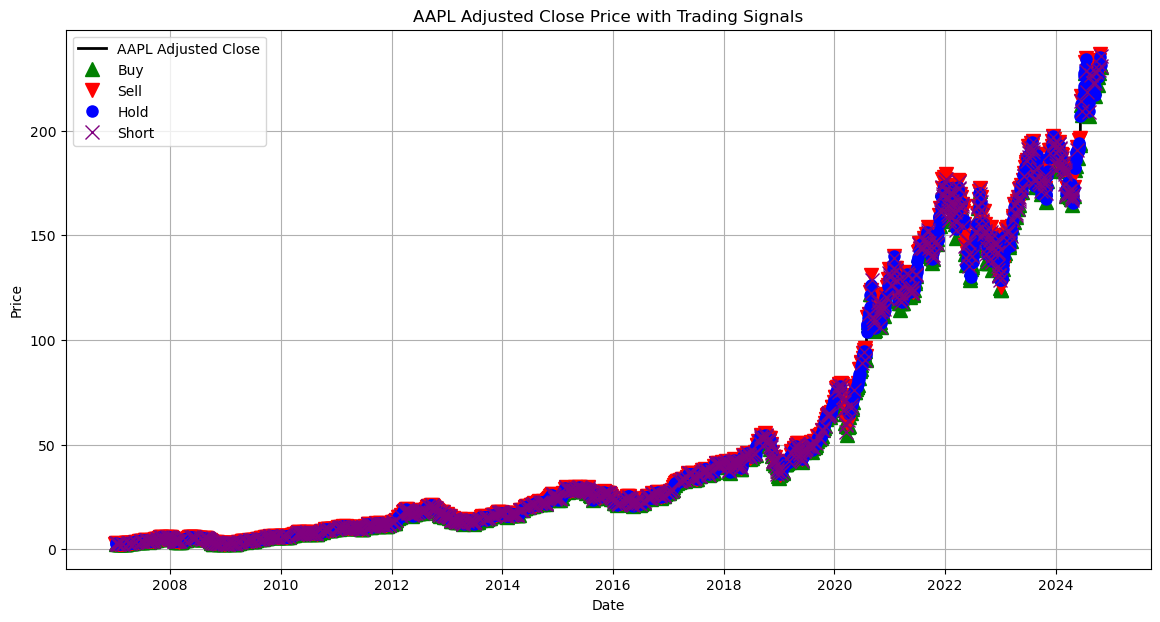

In [22]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


:Overlay
   .Curve.I       :Curve   [index]   (AAPL)
   .Scatter.Buy   :Scatter   [index]   (AAPL)
   .Scatter.Sell  :Scatter   [index]   (AAPL)
   .Scatter.Hold  :Scatter   [index]   (AAPL)
   .Scatter.Short :Scatter   [index]   (AAPL)